In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles,make_classification
import mnist

In [178]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def relu(z):
    return np.maximum(0,z)

def sigmoid_der(z):
    sig = sigmoid(z)
    return sig * (1 - sig)

def relu_der(z):
    if z>0:
        return 1
    else:
        return 0
    
def softmax(z):  
    expZ = np.exp(z)
    return expZ / expZ.sum()

def cross_entropy(X,y):
    
    m = y.shape[0]
    A_L = softmax(X)
    log_likelihood = -np.log(p[range(m),y])
    loss = np.sum(log_likelihood) / m
    return loss

def delta_cross_entropy(A_L,y):
    
#     m = y.shape[0]
#     print(m)
#     grad = softmax(A_L)
#     print(grad.shape)
#     grad[np.arange(m),y] -= 1
#     grad = grad/m
    
    return A_L - y

def print_architecture(kwargs):
    sizes = [kwargs["input_x_shape"]]
    sizes.extend(kwargs["num_units"])

    for i in range(kwargs["num_layers"]):
        print("Dense_{0}---num_units = {1}, input size = ({2},), activation = {3}".format(i,kwargs["num_units"][i],sizes[i],kwargs["activations"][i]))
        print("\n")
        
def load_extra_datasets():  
    N = 200
    gaussian_quantiles = make_gaussian_quantiles(mean=None, cov=0.7, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    return  gaussian_quantiles

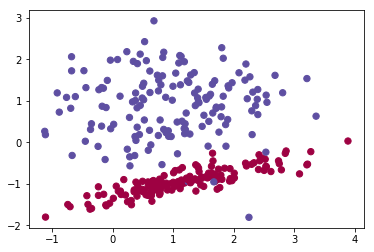

In [179]:
np.random.seed(25)
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1,n_samples=300)

plt.scatter(X1[:,0], X1[:,1], c=Y1, s=40, cmap=plt.cm.Spectral);

In [180]:
x_train, y_train, x_test, y_test = mnist.load()

In [181]:
nb_classes = 10
y_train_one_hote = np.eye(nb_classes)[y_train]
y_test_one_hote = np.eye(nb_classes)[y_test]
x_train = x_train.T
y_train = y_train_one_hote.T

In [214]:
class Network():
    """
    Init function
    """
    def __init__(self,**kwargs):
        self.input_shape = kwargs["input_x_shape"][0]
        self.num_layers = kwargs["num_layers"]
        
        if len(kwargs["num_units"]) != self.num_layers:
            raise ValueError
        else:
            self.num_units = kwargs["num_units"]
            
        self.activations = kwargs["activations"]
        self.W = self.init_weights(kwargs["weights_init_method"])
        self.B = self.init_biases(kwargs["biases_init_method"])
        self.loss = self.set_loss(kwargs["loss"])
        self.zs = []
        self.activations_hist = []
        print_architecture(kwargs)
        
    def init_weights(self,method):
        self.sizes = [self.input_shape]
        self.sizes.extend(self.num_units)
    
        if method == "zeros":
            W = [np.zeros((y, x)) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        elif method == "random":
            W = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
            print(W[1].shape)

        return W
        
    def init_biases(self,method):
        
        if method == "zeros":
            B = [np.zeros(y, 1) for y in self.sizes[1:]]
        elif method == "random":
            B = [np.random.randn(y, 1) for y in self.sizes[1:]]
        return B
    
    def set_loss(self,loss_name):
        if loss_name == "cross_entropy":
            return cross_entropy
        
    def cost_der(self, a_L, y_true):
        return (a_L-y_true)
    
    def feed_forward(self, batch):
        output = batch
        for b, w in zip(self.B, self.W):
            z = np.dot(w, output)+b
            output = sigmoid(z)
            self.zs.append(z)
            self.activations_hist.append(output)
#         return output
    
    def backprop(self,x,y_true):
        nabla_b = [np.zeros(b.shape) for b in self.B]
        nabla_w = [np.zeros(w.shape) for w in self.W]
         
        delta = delta_cross_entropy(self.activations_hist[-1],y_true)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, self.activations_hist[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = self.zs[-l]
            sp = sigmoid_der(z)
            delta = np.dot(self.W[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, self.activations_hist[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def generate_batch(self,X,Y,batch_size):
        idx = np.random.randint(low = 0, high = X.shape[1],size = batch_size)

        return X[:,idx],Y[:,idx]
    
    def update_mini_batch(self, batch, Y_true, lr):
        
        nabla_b = [np.zeros(b.shape) for b in self.B]
        nabla_w = [np.zeros(w.shape) for w in self.W]
        for x, y in zip(batch,Y_true):
            delta_nabla_b, delta_nabla_w = self.backprop(x.reshape(-1,1), y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        self.W = [w-(lr/len(batch))*nw
                        for w, nw in zip(self.W, nabla_w)]
        self.B = [b-(lr/len(batch))*nb
                       for b, nb in zip(self.B, nabla_b)]

    def train(self,X,Y,batch_size=50,epochs=5,steps_per_epoch=100,lr=0.05):
        for j in range(epochs):
            for step in range(steps_per_epoch):
                self.zs = []
                self.activations_hist = []
                batch, Y_true = self.generate_batch(X=X,Y=Y,batch_size=batch_size)
                self.feed_forward(batch)
                self.update_mini_batch(batch,Y_true,lr)
            
    def predict(self,X):
        pass

In [215]:
net_architectur = {
    "input_x_shape":[784,None],
    "batch_size":10,
    "num_layers":3,
    "num_units":[15,12,10],
    "activations":["sigmoid","sigmoid","softmax"],
    "weights_init_method":"random",
    "biases_init_method":"random",
    "loss":"cross_entropy",
    "epochs":3,
    "steps_per_epoch":100
}

In [221]:
net = Network(**net_architectur)
net.train(x_train,y_train,batch_size=50,epochs=100,steps_per_epoch=15,lr=0.01)

(12, 15)
Dense_0---num_units = 15, input size = ([784, None],), activation = sigmoid


Dense_1---num_units = 12, input size = (15,), activation = sigmoid


Dense_2---num_units = 10, input size = (12,), activation = softmax




/root/environments/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [222]:
pred = [np.argmax(net.feed_forward(x_train[:,i].reshape(-1,1))) for i in range(300)]

/root/environments/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [296]:
import numpy as np
# import datasets.mnist.loader as mnist
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
 
 
class Network():
    def __init__(self,**kwargs):
        
        self.input_shape = kwargs["input_x_shape"]
        self.num_layers = kwargs["num_layers"]
        
        if len(kwargs["num_units"]) != self.num_layers:
            raise ValueError
        else:
            self.num_units = kwargs["num_units"]
            
        self.W = self.init_weights(kwargs["weights_init_method"])
        self.B = self.init_biases(kwargs["biases_init_method"])
        print_architecture(kwargs)
        

        self.L = self.num_layers
#         self.n = 0
#         self.costs = []
 
    def init_weights(self,method):
        self.sizes = [self.input_shape]
        self.sizes.extend(self.num_units)
    
        if method == "zeros":
            W = {}
            for l in range(1,len(self.sizes)):
                W["W"+str(l)] = np.zeros((self.sizes[l],self.sizes[l-1]))
        elif method == "random":
            pass

        return W
        
    def init_biases(self,method):
        
        if method == "zeros":
            B = {}
            for l in range(1,len(self.sizes)):
                B["b"+str(l)] = np.zeros((self.sizes[l],1))
                
        elif method == "random":
            pass
        
        return B 
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
 
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)

 
    def forward(self, batch):
        history = {}
 
        A = batch.T
        for l in range(self.L - 1):
            Z = self.W["W" + str(l + 1)].dot(A) + self.B["b" + str(l + 1)]
            A = self.sigmoid(Z)
            store["A" + str(l + 1)] = A
            store["W" + str(l + 1)] = self.parameters["W" + str(l + 1)]
            store["Z" + str(l + 1)] = Z
 
        Z = self.W["W" + str(self.L)].dot(A) + self.B["b" + str(self.L)]
        A = self.softmax(Z)
        history["A" + str(self.L)] = A
        history["W" + str(self.L)] = self.W["W" + str(self.L)]
        history["Z" + str(self.L)] = Z
 
        return A, store
 
#     def sigmoid_derivative(self, Z):
#         s = 1 / (1 + np.exp(-Z))
#         return s * (1 - s)
 
#     def backward(self, X, Y, store):
 
#         derivatives = {}
 
#         store["A0"] = X.T
 
#         A = store["A" + str(self.L)]
#         dZ = A - Y.T
 
#         dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n
#         db = np.sum(dZ, axis=1, keepdims=True) / self.n
#         dAPrev = store["W" + str(self.L)].T.dot(dZ)
 
#         derivatives["dW" + str(self.L)] = dW
#         derivatives["db" + str(self.L)] = db
 
#         for l in range(self.L - 1, 0, -1):
#             dZ = dAPrev * self.sigmoid_derivative(store["Z" + str(l)])
#             dW = 1. / self.n * dZ.dot(store["A" + str(l - 1)].T)
#             db = 1. / self.n * np.sum(dZ, axis=1, keepdims=True)
#             if l > 1:
#                 dAPrev = store["W" + str(l)].T.dot(dZ)
 
#             derivatives["dW" + str(l)] = dW
#             derivatives["db" + str(l)] = db
 
#         return derivatives
 
#     def fit(self, X, Y, learning_rate=0.01, n_iterations=2500):
#         np.random.seed(1)
 
#         self.n = X.shape[0]
 
#         self.layers_size.insert(0, X.shape[1])
 
#         self.initialize_parameters()
#         for loop in range(n_iterations):
#             A, store = self.forward(X)
#             cost = -np.mean(Y * np.log(A.T+ 1e-8))
#             derivatives = self.backward(X, Y, store)
 
#             for l in range(1, self.L + 1):
#                 self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - learning_rate * derivatives[
#                     "dW" + str(l)]
#                 self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - learning_rate * derivatives[
#                     "db" + str(l)]
 
#             if loop % 100 == 0:
#                 print("Cost: ", cost, "Train Accuracy:", self.predict(X, Y))
 
#             if loop % 10 == 0:
#                 self.costs.append(cost)
 
#     def predict(self, X, Y):
#         A, cache = self.forward(X)
#         y_hat = np.argmax(A, axis=0)
#         Y = np.argmax(Y, axis=1)
#         accuracy = (y_hat == Y).mean()
#         return accuracy * 100
 
#     def plot_cost(self):
#         plt.figure()
#         plt.plot(np.arange(len(self.costs)), self.costs)
#         plt.xlabel("epochs")
#         plt.ylabel("cost")
#         plt.show()
 
 
# def pre_process_data(train_x, train_y, test_x, test_y):
#     # Normalize
#     train_x = train_x / 255.
#     test_x = test_x / 255.
 
#     enc = OneHotEncoder(sparse=False, categories='auto')
#     train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))
 
#     test_y = enc.transform(test_y.reshape(len(test_y), -1))
 
#     return train_x, train_y, test_x, test_y
 

layers_dims = [20,15,10]
 
ann = Network(**net_architectur)
 
w = ann.W
# if __name__ == '__main__':
#     train_x, train_y, test_x, test_y = mnist.load()
 
#     train_x, train_y, test_x, test_y = pre_process_data(train_x, train_y, test_x, test_y)
 
#     print("train_x's shape: " + str(train_x.shape))
#     print("test_x's shape: " + str(test_x.shape))
 
#     layers_dims = [50,50, 10]
 
#     ann = ANN(layers_dims)
#     ann.fit(train_x, train_y, learning_rate=0.1, n_iterations=1000)
#     print("Train Accuracy:", ann.predict(train_x, train_y))
#     print("Test Accuracy:", ann.predict(test_x, test_y))
#     ann.plot_cost()

Dense_0---num_units = 15, input size = (784,), activation = sigmoid


Dense_1---num_units = 12, input size = (15,), activation = sigmoid


Dense_2---num_units = 10, input size = (12,), activation = softmax




In [297]:
net_architectur = {
    "input_x_shape":784,
    "batch_size":10,
    "num_layers":3,
    "num_units":[15,12,10],
    "activations":["sigmoid","sigmoid","softmax"],
    "weights_init_method":"zeros",
    "biases_init_method":"zeros",
    "loss":"cross_entropy",
    "epochs":3,
    "steps_per_epoch":100
}

In [298]:
w["W3"].shape

(10, 12)

In [299]:
np.dot(w["W1"],np.ones((,784))).shape

ValueError: shapes (15,784) and (1,784) not aligned: 784 (dim 1) != 1 (dim 0)

In [286]:
x_0 = x_train[:,:2]

In [295]:
ann.forward(batch = x_0)

ValueError: shapes (784,15) and (2,784) not aligned: 15 (dim 1) != 2 (dim 0)

In [287]:
x_0.shape

(784, 2)

In [290]:
class ANN:
    def __init__(self, layers_size):
        self.layers_size = layers_size
        self.parameters = {}
        self.L = len(self.layers_size)
        self.n = 0
        self.costs = []
 
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
 
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
 
    def initialize_parameters(self):
        np.random.seed(1)
 
        for l in range(1, len(self.layers_size)):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_size[l], self.layers_size[l - 1]) / np.sqrt(
                self.layers_size[l - 1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_size[l], 1))
 
    def forward(self, X):
        store = {}
 
        A = X.T
        for l in range(self.L - 1):
            Z = self.parameters["W" + str(l + 1)].dot(A) + self.parameters["b" + str(l + 1)]
            A = self.sigmoid(Z)
            store["A" + str(l + 1)] = A
            store["W" + str(l + 1)] = self.parameters["W" + str(l + 1)]
            store["Z" + str(l + 1)] = Z
 
        Z = self.parameters["W" + str(self.L)].dot(A) + self.parameters["b" + str(self.L)]
        A = self.softmax(Z)
        store["A" + str(self.L)] = A
        store["W" + str(self.L)] = self.parameters["W" + str(self.L)]
        store["Z" + str(self.L)] = Z
 
        return A, store
 
    def sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return s * (1 - s)
 
    def backward(self, X, Y, store):
 
        derivatives = {}
 
        store["A0"] = X.T
 
        A = store["A" + str(self.L)]
        dZ = A - Y.T
 
        dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n
        db = np.sum(dZ, axis=1, keepdims=True) / self.n
        dAPrev = store["W" + str(self.L)].T.dot(dZ)
 
        derivatives["dW" + str(self.L)] = dW
        derivatives["db" + str(self.L)] = db
 
        for l in range(self.L - 1, 0, -1):
            dZ = dAPrev * self.sigmoid_derivative(store["Z" + str(l)])
            dW = 1. / self.n * dZ.dot(store["A" + str(l - 1)].T)
            db = 1. / self.n * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = store["W" + str(l)].T.dot(dZ)
 
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db
 
        return derivatives
 
    def fit(self, X, Y, learning_rate=0.01, n_iterations=2500):
        np.random.seed(1)
 
        self.n = X.shape[0]
 
        self.layers_size.insert(0, X.shape[1])
 
        self.initialize_parameters()
        for loop in range(n_iterations):
            A, store = self.forward(X)
            cost = -np.mean(Y * np.log(A.T+ 1e-8))
            derivatives = self.backward(X, Y, store)
 
            for l in range(1, self.L + 1):
                self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - learning_rate * derivatives[
                    "dW" + str(l)]
                self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - learning_rate * derivatives[
                    "db" + str(l)]
 
            if loop % 100 == 0:
                print("Cost: ", cost, "Train Accuracy:", self.predict(X, Y))
 
            if loop % 10 == 0:
                self.costs.append(cost)
 
    def predict(self, X, Y):
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100
 
    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()
 
 
def pre_process_data(train_x, train_y, test_x, test_y):
    # Normalize
    train_x = train_x / 255.
    test_x = test_x / 255.
 
    enc = OneHotEncoder(sparse=False, categories='auto')
    train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))
 
    test_y = enc.transform(test_y.reshape(len(test_y), -1))
 
    return train_x, train_y, test_x, test_y
 
 
if __name__ == '__main__':
    train_x, train_y, test_x, test_y = mnist.load()
 
    train_x, train_y, test_x, test_y = pre_process_data(train_x, train_y, test_x, test_y)
 
    print("train_x's shape: " + str(train_x.shape))
    print("test_x's shape: " + str(test_x.shape))
 
    layers_dims = [50, 10]
 
    ann = ANN(layers_dims)
    ann.fit(train_x, train_y, learning_rate=0.1, n_iterations=1000)
    print("Train Accuracy:", ann.predict(train_x, train_y))
    print("Test Accuracy:", ann.predict(test_x, test_y))
    ann.plot_cost()

train_x's shape: (60000, 784)
test_x's shape: (10000, 784)
Cost:  0.24014289805733696 Train Accuracy: 8.393333333333333


KeyboardInterrupt: 